In [23]:
import numpy as np
import scipy as sp
from scipy import io
import cv2 as cv 
import matplotlib.pyplot as plt
import pylab
import os # for reading all files in a folder
#pylab.rcParams['figure.figsize'] = (12.0, 10.0)
# I changed the size to  (3, 2.5) because my laptop is trash and I can't load large size.

# Part H: Tracking and Homographies

In this part we use Practical 7c to track the positions of the four corners of the square and project a cube into the images. 

TO DO: QUESTIONS TO THINK ABOUT...

- Do the results look realistic? 
- If not then what factors do you think might be causing this


TO DO: your routines for computing a homography and extracting a valid rotation and translation go in the code below. Tips:
- you may define functions for T and H matrices respectively.
- you may need to turn the points into homogeneous form before any other computation. 
- you may need to solve a linear system in Ah = 0 form. Write your own routines or using the builtin function 'svd'. 
- you may apply the direct linear transform (DLT) algorithm to recover the best homography H.
- you may explain what & why you did in the report.


In [24]:
# TO DO: Copy and paste the function HW2_Practical7c in here. 

def computeLikelihood(image, template):
    #opencv's available methods - experiment with these
    #careful what range the output is!
    methods = [cv.TM_CCOEFF, cv.TM_CCOEFF_NORMED, cv.TM_CCORR,
            cv.TM_CCORR_NORMED, cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]
    
    likelihood = cv.matchTemplate(image[:,:,2], template, methods[0])
    # (You can also try converting the image to greyscale instead of using the third channel as above with 
    # cv.cvtColor(image, cv.COLOR_BGR2GRAY))
    
    #we can pad to make this the size of the input image (for easier indexing)   
    pad_first = int(template.shape[0])
    pad_second = int(template.shape[1])
    pad_amounts = ((0, pad_first-1), (0, pad_second-1))
    likelihood = np.pad(likelihood, pad_amounts, 'constant')
    likelihood[likelihood<0] = 0 # to avoid negative weights 
    
    # apply a 10x10 averaging filter for stability. You can experiment with different sizes. 
    kernel = np.ones((10,10),np.float32)/100
    smoothed = cv.filter2D(likelihood,-1,kernel) 
    return smoothed 

In [26]:
def HW2_Practical7c(corner):
    template = sp.io.loadmat(corner+'.mat')['pixelsTemplate']
    #let's show the template
    print('We are matching this template with shape: ', template.shape)
    plt.imshow(template)
    plt.show()

    # Load all images in folder
    images = []
    iFrame = 0
    folder = 'Pattern01/'
    lst = os.listdir(folder)
    lst.sort()

    for frameNum in lst:
        images.append(cv.imread(folder+frameNum))
        iFrame += 1
    # plot first image 
    plt.imshow(images[0])
    plt.show()

    imgHeight, imgWidth, colors = images[0].shape
    numParticles = 2000;
    weight_of_samples = np.ones((numParticles,1))

    # TO DO: normalize the weights (may be trivial this time) [done]
    weight_of_samples = weight_of_samples/np.sum(weight_of_samples) #replace this

    # Initialize which samples from "last time" we want to propagate: all of
    # them!:
    samples_to_propagate = range(0, numParticles)


    # ============================
    # NOT A TO DO: You don't need to change the code below, but eventually you may
    # want to vary the number of Dims (compare for example to lab 9b) 
    numDims_w = 2;
    # Here we randomly initialize some particles throughout the space of w:
    particles_old = np.random.rand(numParticles, numDims_w)
    particles_old[:,0] = particles_old[:,0] * imgHeight
    particles_old[:,1] = particles_old[:,1] * imgWidth
    # ============================

    #Initialize a temporary array r to store the per-frame MAP estimate of w. This is what we'll return in the end.
    r = np.zeros((iFrame, numDims_w));

    for iTime in range(iFrame):
        print('Processing Frame', iTime)
        # TO DO: compute the cumulative sume of the weights. [done]
        cum_hist_of_weights = np.cumsum(weight_of_samples) # replace this
        #print(weight_of_samples)


        # ==============================================================
        # Resample the old distribution at time t-1, and select samples, favoring
        # those that had a higher posterior probability.
        # ==============================================================
        samples_to_propagate = np.zeros(numParticles, dtype=np.int32)

        # Pick random thresholds in the cumulative probability's range [0,1]:
        some_threshes = np.random.rand(numParticles)


        # For each random threshold, find which sample in the ordered set is
        # the first one to push the cumulative probability above that
        # threshold, e.g. if the cumulative histogram goes from 0.23 to 0.26
        # between the 17th and 18th samples in the old distribution, and the
        # threshold is 0.234, then we'll want to propagate the 18th sample's w
        # (i.e. particle #18).

        for sampNum in range(numParticles): 
            thresh = some_threshes[sampNum]
            for index in range (numParticles):
                if cum_hist_of_weights[index] > thresh:
                    break
            samples_to_propagate[sampNum] = index

        # Note: it's ok if some of the old particles get picked repeatedly, while
        # others don't get picked at all.


        # =================================================
        # Visualize if you want
        # =================================================
        #plt.title('Cumulative histogram of probabilities for sorted list of particles')
        #plt.plot(np.zeros(numParticles), some_threshes,'b.')
        #plt.plot(range(0, numParticles), cum_hist_of_weights, 'rx-')
        #which_sample_ids = np.unique(samples_to_propagate)
        #how_many_of_each = np.bincount(np.ravel(samples_to_propagate))
        #for k in range(len(which_sample_ids)):
        #    plt.plot(which_sample_ids[k], 0, 'bo-', markersize = 3 * how_many_of_each[k], markerfacecolor='white')
        #plt.xlabel('Indeces of all available samples, with larger blue circles for frequently re-sampled particles\n(Iteration %01d)' % iTime)
        #plt.ylabel('Cumulative probability');
        #plt.show()
        # =================================================
        # =================================================

        # Predict where the particles we sampled from the old distribution of 
        # state-space will go in the next time-step. This means we have to apply 
        # the motion model to each old sample.
        particles_new = np.zeros_like(particles_old)
        for particleNum in range(numParticles):
            # TO DO: Incorporate some noise, e.g. Gaussian noise with std 20,
            # into the current location (particles_old), to give a Brownian
            # motion model.
            noise = np.random.normal(0,20,2)
            particles_new[particleNum, :] =  particles_old[samples_to_propagate[particleNum], :] + noise
            
        # TO DO: Not initially, but change the motion model above to have
        # different degrees of freedom, and optionally completely different
        # motion models. See Extra Credit for more instructions.

        #calculate likelihood function
        likelihood = computeLikelihood(images[iTime], template)

        #plot results
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(images[iTime])
        axarr[0].set_title('Particles')
        # now draw the particles onto the image
        axarr[0].plot(particles_new[:,1]+template.shape[1]/2, particles_new[:,0]+template.shape[0]/2, 'rx')

        #plot the likelihood
        axarr[1].imshow(likelihood)
        axarr[1].set_title('Likelihood')





        # From here we incorporate the data for the new state (time t):
        # The new particles accompanying predicted locations in state-space
        # for time t, are missing their weights: how well does each particle
        # explain the observations x_t?
        for particleNum in range(numParticles):

            # Convert the particle from state-space w to measurement-space x:
            # Note: that step is trivial here since both are in 2D space of image
            # coordinates

            # Within the loop, we evaluate the likelihood of each particle:
            particle = particles_new[particleNum, :]
            # Check that the predicted location is a place we can really evaluate
            # the likelihood.
            inFrame = particle[0] >= 0.0 and  particle[0] <= imgHeight and particle[1] >= 0.0 and particle[1] <= imgWidth
            if inFrame:
                minX = particle[1]
                minY = particle[0]

                weight_of_samples[particleNum] = likelihood[int(minY), int(minX)]

            else:
                weight_of_samples[particleNum] = 0.0

        # TO DO: normalize the weights [done]
        weight_of_samples = weight_of_samples/np.sum(weight_of_samples) # replace this
        
        # find the location of the particle with highest weight
        indices = np.argsort(weight_of_samples,0)
        bestScoringParticles = particles_new[np.squeeze(indices[-15:]), :]
        plt.plot(bestScoringParticles[-1:,1], bestScoringParticles[-1:,0], 'rx')
        # Return the MAP of middle position. Add template.shape/2 because matchTemplate finds the position of the upper left corner 
        # of the template. We want to plot the centre of the template. 
        r[iTime,:] = bestScoringParticles[-1,1]+template.shape[1]/2,bestScoringParticles[-1,0]+template.shape[0]/2
        print(r[iTime,:])   
        plt.show()

        #print the original image and the position of the tracked corner.
        plt.imshow(images[iTime])
        plt.plot(r[iTime,0],r[iTime,1],'rx')
        plt.show()
        # Now we're done updating the state for time t. 
        # For Condensation, just clean up and prepare for the next round of 
        # predictions and measurements:
        particles_old = particles_new

    return r

In [ ]:
# instead of running the code here, you can also save the output of each function in a numpy array in HW2_Practical7c 
# and load it here. This could be handy if you need different hyperparameters for each corner.

pylab.rcParams['figure.figsize'] = (3, 3)  #change to smaller size
LLs = HW2_Practical7c( 'll' )
LRs = HW2_Practical7c( 'lr' )
ULs = HW2_Practical7c( 'ul' )
URs = HW2_Practical7c( 'ur' )

This time-consuming plots above show an estimated pattern of 2D-location over time about one of the corners. The particle distributed randomly at the beginning, and then they move to the area which has high posterior. Lastly, all the points concentrate on the corner.

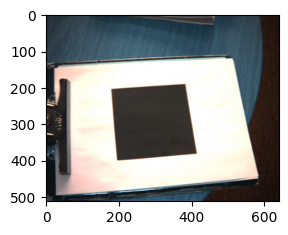

In [28]:
# Load all images in folder
images = []
nFrame = 0
folder = 'Pattern01/'
lst = os.listdir(folder)
lst.sort()

for frameNum in lst:
    images.append(cv.imread(folder+frameNum))
    nFrame += 1
# plot first image 
plt.imshow(images[0])
plt.show()


# Coordinates of the known target object (a dark square on a plane) in 3D:
XCart = np.array([[-50, -50,  50,  50],
          [50, -50, -50,  50],
            [0, 0, 0, 0]])

# These are some approximate intrinsics for this footage.
K = np.array([[640, 0, 320],
          [0, 512, 256],
            [0, 0, 1]])

# Define 3D points of wireframe object.
XWireFrameCart = np.array([[-50, -50,  50,  50, -50, -50,  50,  50],
          [50, -50, -50,  50, 50, -50, -50,  50],
            [0, 0, 0, 0, -100, -100, -100, -100, ]])

In [29]:
def projectiveCamera(K,T,XCart):
    ##TODO
    # The goal of this function is to project points in XCart through projective camera
    # defined by intrinsic matrix K and extrinsic matrix T. In essence, this function takes a set of points 
    # in 3D world space, XCart, and projects them into camera image space by applying the extrinsic matrix T 
    # and then applying the intrinsic matrix K.
    # 
    # There are three steps.
    # 1) Move from world space to camera space. 
    #            camera space points = extrinsics T * world space points 
    #
    # 2) Applying the intrinsics matrix to the camera space points after normalizing
    #           homogeneous image space points = K * normalized camera space points
    # 
    # 3) Move to image space cartesian points from image space homogeneous points, involves a 
    # normalization using the third row.
    
    
    # TODO: Convert Cartesian 3d points XCart to homogeneous coordinates XHom
    # Add a row of ones to convert 3D points into homogeneous coordinates
    XHom = np.concatenate((XCart, np.ones((1, XCart.shape[1]))), axis=0)
    
    # TODO: Apply extrinsic matrix to XHom, to move to the frame of reference of the camera
    # Transform points to camera space.
    # T is 4x4 matrix XHom is 4xN matrix
    XCamHom = np.matmul(T, XHom)

    # TODO: Project points into normalized camera coordinates xCamHom (remove 4th row)
    # Normalize by dividing by the fourth row (homogeneous to Cartesian conversion)
    XCamHom = XCamHom[:3, :] / XCamHom[3, :]

    # TODO: Move points to image coordinates xImHom by applying intrinsic matrix
    # Apply the intrinsic matrix K to camera coordinates
    xImHom = np.matmul(K, XCamHom)

    # TODO: Convert points back to Cartesian coordinates xImCart
    # Normalize by the third row to return to Cartesian coordinates
    XImCart = xImHom[:2, :] / xImHom[2, :]

    return XImCart


In [30]:
def solveAXEqualsZero(A):
    # TODO: Write this routine - it should solve Ah = 0. You can do this using SVD. Consult your notes!
    # Hint: SVD will be involved.

    # Perform Singular Value Decomposition
    U, S, V = np.linalg.svd(A)
    
    # The solution to Ah = 0 is the last column of V (or last row of V transposed, V_t)
    h = (V.T)[:, -1]
    
    return h

In [31]:
def calcBestHomography(pts1Cart, pts2Cart):
    
    # This function should apply the direct linear transform (DLT) algorithm to calculate the best 
    # homography that maps the cartesian points in pts1Cart to their corresonding matching cartesian poitns 
    # in pts2Cart.
    
    # This function calls solveAXEqualsZero. Make sure you are wary of how to reshape h into a 3 by 3 matrix. 

    n_points = pts1Cart.shape[1]
    
    pts1Hom = np.concatenate((pts1Cart, np.ones((1,pts1Cart.shape[1]))), axis=0)
    
    # Construct matrix A (size: n_points * 2 , 9)
    A = np.zeros((n_points * 2, 9))

    u = pts1Hom[0,:]
    v = pts1Hom[1,:]
    x = pts2Cart[0,:]
    y = pts2Cart[1,:]

    for i in range (n_points):
        A[2*i] = np.array([0,0,0,-1*u[i], -1*v[i], -1, y[i]*u[i], y[i]*v[i], y[i]])
        A[2*i+1] = np.array([u[i], v[i], 1, 0, 0, 0, -1*x[i]*u[i], -1*x[i]*v[i], -1*x[i]])
    
    # Solve Ah = 0 using solveAXEqualsZero and get h.
    h= solveAXEqualsZero(A)
    
    # Reshape h into the matrix H, values of h go first into rows of H
    H = h.reshape((3,3))
    
    return H

In [32]:
# Read the next cell first for context!

def estimatePlanePose(XImCart,XCart,K):
    # The goal of this function is to estimate the pose of a plane relative to camera (extrinsic matrix)
    # given points in image space xImCart, points in 3D world space XCart, and an intrinsics matrix K.

    # TODO: Convert Cartesian image points XImCart to homogeneous representation XImHom
    XImHom = np.concatenate((XImCart, np.ones((1, XImCart.shape[1]))), axis=0)
    
    # TODO: Convert image co-ordinates XImHom to normalized camera coordinates XCamHom    
    XCamHom = np.matmul(np.linalg.inv(K), XImHom)

    
    # TODO: Estimate homography H mapping homogeneous (x,y) coordinates of positions
    # in real world to XCamHom (convert XCamHom to Cartesian, calculate the homography) -
    # use the routine you wrote for Practical 1B
    H = calcBestHomography(XCart[:2, :], XCamHom[:2, :])
          
    # TODO: Estimate first two columns of rotation matrix R from the first two
    # columns of H using the SVD. NOTE: You do not need to transpose v from linalg.svd    
    U,L,Vt = np.linalg.svd(H[:,0:2]) 
    rota = np.array([[1,0],[0,1],[0,0]])
    R = np.zeros((3,3))
    R12 = U@rota@Vt 

    # TODO: Estimate the third column of the rotation matrix by taking the cross
    # product of the first two columns
    R3 = np.cross(R12[:, 0], R12[:, 1])
    R = np.column_stack((R12, R3))
   
        
    # TODO: Check that the determinant of the rotation matrix is positive - if
    # not then multiply last column by -1.
    if np.linalg.det(R) <= 0:
        R[:, 2] *= -1

    
    # TODO: Estimate the translation t by finding the appropriate scaling factor k
    # and applying it to the third colulmn of H
    t = (H[:, 2] / (np.mean(H[:,:2]/R[:,:2]))).reshape(3,1)
    
    # TODO: Check whether t_z is negative - if it is then multiply t by -1 and
    # the first two columns of R by -1.
    if t[2] < 0:
        t *= -1
        R[:, :2] *= -1
            
    # TODO: Assemble transformation into matrix form
    T = np.hstack((R,t)) 
    T = np.vstack((T, np.array([0,0,0,1]))) 
    
    return T 

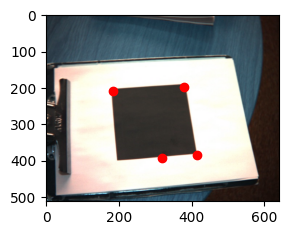

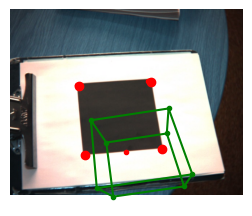

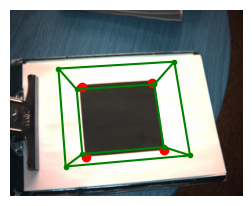

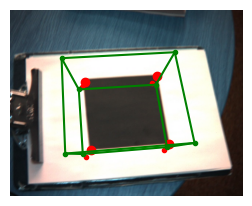

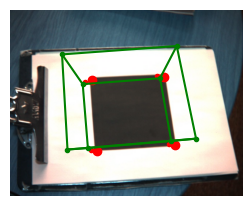

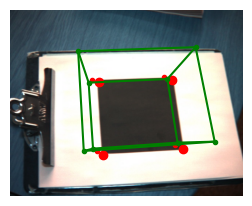

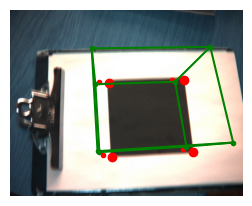

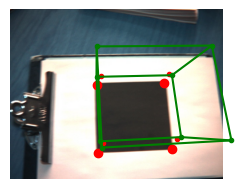

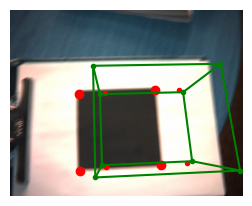

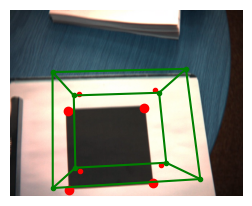

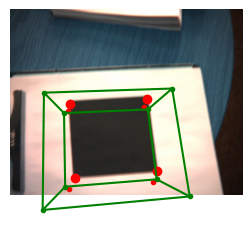

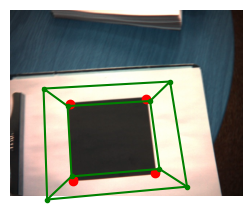

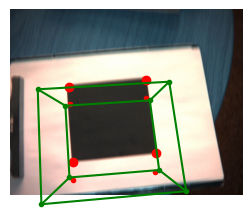

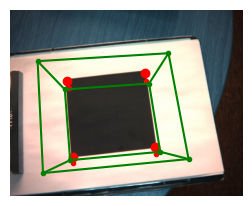

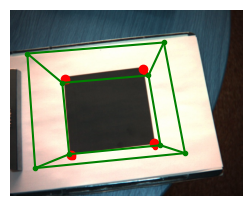

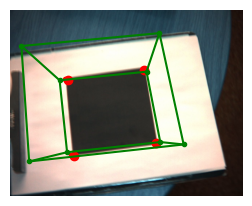

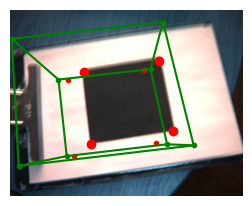

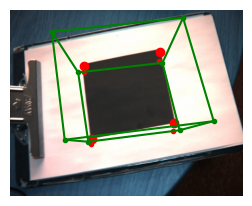

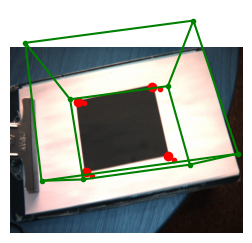

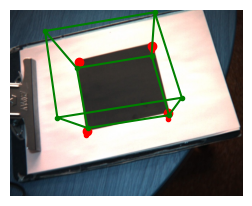

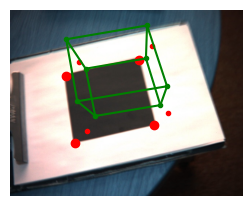

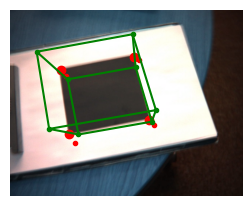

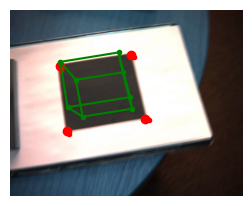

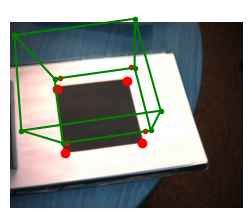

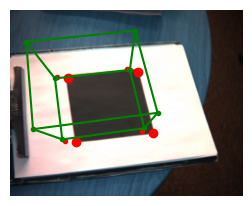

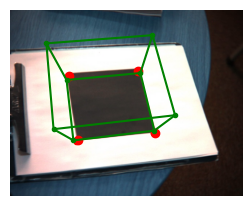

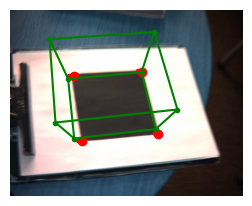

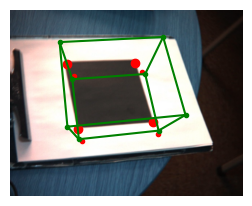

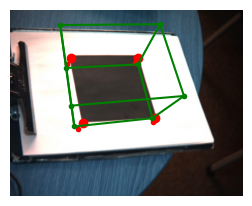

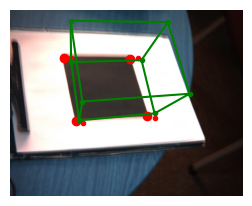

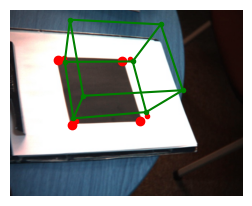

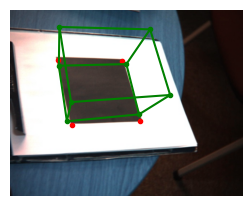

In [33]:
# ================================================
for iFrame in range(nFrame):
    #xImCart = np.array([LLs[iFrame,:].T, ULs[iFrame,:].T, URs[iFrame,:].T, LRs[iFrame,:].T]).T

    # get a frame from footage 
    #im = images[iFrame]

    # Draw image and 2d points
    #plt.imshow(im)
    #plt.scatter(x = xImCart[0,:], y = xImCart[1,:],c = 'r')
    #plt.show()
    if iFrame%5 == 0:
        xImCart = np.array([LLs[iFrame,:].T, ULs[iFrame,:].T, URs[iFrame,:].T, LRs[iFrame,:].T]).T

        # get a frame from footage 
        im = images[iFrame]

        # Draw image and 2d points
        plt.imshow(im)
        plt.scatter(x = xImCart[0,:], y = xImCart[1,:],c = 'r')
        plt.show()


        #TO DO: Use your routine to calculate TEst the extrinsic matrix relating the
        #plane position to the camera position.
        T = estimatePlanePose(xImCart, XCart, K)
        XWireFrameCartProjected = projectiveCamera(K,T,XWireFrameCart)
    
        # TO DO: Draw a wire frame cube using data XWireFrameCart. You need to
        # 1) project the vertices of a 3D cube through the projective camera;
        # 2) draw lines between the resulting 2d image points.
        # Note: CONDUCT YOUR CODE FOR DRAWING XWireFrameCart HERE
        plt.imshow(im)
        plt.plot(xImCart[0,],xImCart[1,],'r.')
        plt.plot(XWireFrameCartProjected[0,],XWireFrameCartProjected[1,],'g.')

        # side
        plt.plot([XWireFrameCartProjected[0,0], XWireFrameCartProjected[0,4]], [XWireFrameCartProjected[1,0], XWireFrameCartProjected[1,4]],'g-')
        plt.plot([XWireFrameCartProjected[0,1], XWireFrameCartProjected[0,5]], [XWireFrameCartProjected[1,1], XWireFrameCartProjected[1,5]],'g-')
        plt.plot([XWireFrameCartProjected[0,2], XWireFrameCartProjected[0,6]], [XWireFrameCartProjected[1,2], XWireFrameCartProjected[1,6]],'g-')
        plt.plot([XWireFrameCartProjected[0,3], XWireFrameCartProjected[0,7]], [XWireFrameCartProjected[1,3], XWireFrameCartProjected[1,7]],'g-')

        # bottom
        plt.plot([XWireFrameCartProjected[0,0], XWireFrameCartProjected[0,1]], [XWireFrameCartProjected[1,0], XWireFrameCartProjected[1,1]],'g-')     
        plt.plot([XWireFrameCartProjected[0,1], XWireFrameCartProjected[0,2]], [XWireFrameCartProjected[1,1], XWireFrameCartProjected[1,2]],'g-')     
        plt.plot([XWireFrameCartProjected[0,2], XWireFrameCartProjected[0,3]], [XWireFrameCartProjected[1,2], XWireFrameCartProjected[1,3]],'g-')     
        plt.plot([XWireFrameCartProjected[0,0],XWireFrameCartProjected[0,3]], [XWireFrameCartProjected[1,0],XWireFrameCartProjected[1,3]],'g-') 

        # top
        plt.plot([XWireFrameCartProjected[0,4],XWireFrameCartProjected[0,5]], [XWireFrameCartProjected[1,4],XWireFrameCartProjected[1,5]],'g-')
        plt.plot([XWireFrameCartProjected[0,5],XWireFrameCartProjected[0,6]], [XWireFrameCartProjected[1,5],XWireFrameCartProjected[1,6]],'g-')
        plt.plot([XWireFrameCartProjected[0,6],XWireFrameCartProjected[0,7]], [XWireFrameCartProjected[1,6],XWireFrameCartProjected[1,7]],'g-')
        plt.plot([XWireFrameCartProjected[0,4],XWireFrameCartProjected[0,7]], [XWireFrameCartProjected[1,4],XWireFrameCartProjected[1,7]],'g-') 

        plt.axis('off')

The plots above show the real 2d-points (red points) and estimated 3D-cube points (green lines). The green lines connect the projected 3D cube points and construct an estimated 3D cube. 

 We can see that the estimated points do not match the real corners perfectly at the beginning, although the matches becomes better as the process go on. As we explained before in practical2B. This might be caused by the error when calculating SVD (used for computing the homography) and tracking the corners.

To improve the results we could use more points to track the corners, edges and centres of the 2D square, and we might use more states and consider the relations among previous frames, which might help to increase the accuracy.